#Mounting Google Drive

---



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
pip install -U ydata_profiling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from ydata_profiling import ProfileReport
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report


nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

DataFrame lenght: 21966


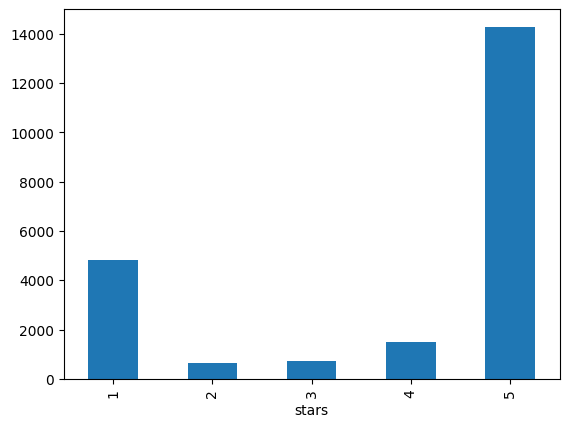

In [ ]:
# open csv file
reviews_df = pd.read_csv("/content/gdrive/MyDrive/CW/reviews_for_classification.csv")
headers = ['name', 'country', 'date_time', 'stars', 'review_head', 'review_body']
reviews_df.columns = headers

# select nesessary columns
df = reviews_df[['stars', 'review_body']]
# get value counts of stars
df.stars.value_counts().sort_index(ascending=True).plot(kind='bar')
# lenght of DataFrame
print(f'DataFrame lenght: {len(df)}')

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/CW/reviews_for_classification.csv")
reviews_df = df.drop(df.columns[[0, 1, 2, 4]], axis=1)

In [ ]:
reviews_df

,stars,review_body
0,5,The best in all that matters! It's a great pla...
1,5,If you are looking for the best #HomeForCrypto...
2,1,I despise it so much. Transferring to other wa...
3,1,Worst customer service and worst company to de...
4,5,Celsius is the most transparent and responsive...
...,...,...
21961,1,Worst service ever. I was emailed to contact t...
21962,5,NaN
21963,5,PNC has been my banking partner for over 25+ y...
21964,5,"My only most trusted bank in 11 years, please ..."


In [ ]:
#Inital analysis of raw data

profile = ProfileReport(reviews_df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Data Cleaning
reviews_df['review_body'] = reviews_df['review_body'].replace('', pd.NA)  # Replace empty fields with pd.NA
reviews_df = reviews_df[reviews_df['review_body'].notna()]  # Remove rows with empty fields
reviews_df = reviews_df[reviews_df['review_body'].str.lower() != 'none']  # Remove rows with 'None' (case insensitive)

# Additional Text Preprocessing
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove unnecessary whitespaces
    text = ' '.join(text.split())
    return text

reviews_df['review_body'] = reviews_df['review_body'].apply(preprocess_text)
reviews_df['features'] = reviews_df['review_body'].apply(lambda x: TextBlob(str(x)).noun_phrases)

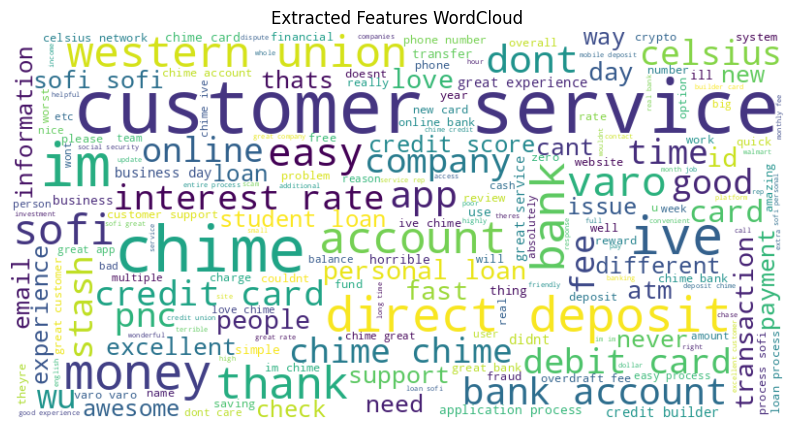

In [ ]:
# WordCloud for the entire dataset
all_features = [feature for sublist in reviews_df['features'] for feature in sublist]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_features))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Extracted Features WordCloud')
plt.show()


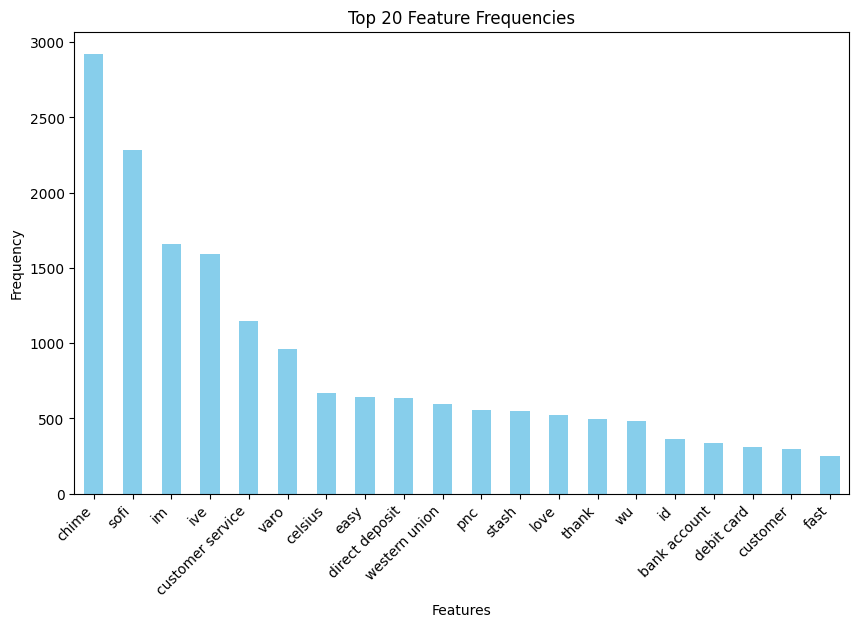

In [ ]:
feature_counts = pd.Series(all_features).value_counts()

top_20_features = feature_counts.head(20)

plt.figure(figsize=(10, 6))
top_20_features.plot(kind='bar', color='skyblue')
plt.title('Top 20 Feature Frequencies')
plt.xlabel('Features')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Set a threshold for positive and negative ratings
positive_threshold = 4
negative_threshold = 2

# Convert numeric ratings to categorical labels
reviews_df['sentiment'] = pd.cut(reviews_df['stars'], bins=[-float('inf'), negative_threshold, positive_threshold, float('inf')],
                                 labels=['negative', 'neutral', 'positive'], include_lowest=True)

In [ ]:
reviews_df

,stars,review_body,features,sentiment
0,5,The best in all that matters Its a great platf...,"[great platform, phone number, highly, good th...",positive
1,5,If you are looking for the best HomeForCrypto ...,"[homeforcrypto, steady yield, celsius network,...",positive
2,1,I despise it so much Transferring to other wal...,"[transferring, verification, cryptocom, im]",negative
3,1,Worst customer service and worst company to de...,"[worst, customer service, dont waste, bs be aw...",negative
4,5,Celsius is the most transparent and responsive...,"[celsius, responsive company, ive, crypto spac...",positive
...,...,...,...,...
21960,3,Had a random fee on my account Called the virt...,"[random fee, virtual wallet customer service l...",neutral
21961,1,Worst service ever I was emailed to contact th...,"[worst, dontdo, pnc bank]",negative
21963,5,PNC has been my banking partner for over 25 ye...,"[pnc, great customer service]",positive
21964,5,My only most trusted bank in 11 years please k...,[good fashion],positive


In [ ]:
# Encode the sentiment labels
label_encoder = LabelEncoder()
reviews_df['encoded_sentiment'] = label_encoder.fit_transform(reviews_df['sentiment'])

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    reviews_df['review_body'], reviews_df['encoded_sentiment'], test_size=0.2, random_state=42
)

# Tokenize the text data
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

# Pad sequences to have the same length
max_sequence_length = 100
train_data_padded = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_data_padded = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Build the model
embedding_dim = 50
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=100))
model.add(Dropout(0.5))
model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data_padded, train_labels, epochs=5,  batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_data_padded, test_labels)
print(f'Test accuracy: {accuracy * 100:.2f}%')

Epoch 1/5
186/186 [==============================] - 38s 192ms/step - loss: 0.6086 - accuracy: 0.7734 - val_loss: 0.4152 - val_accuracy: 0.8541
Epoch 2/5
186/186 [==============================] - 35s 188ms/step - loss: 0.3517 - accuracy: 0.8705 - val_loss: 0.3604 - val_accuracy: 0.8702
Epoch 3/5
186/186 [==============================] - 42s 226ms/step - loss: 0.2764 - accuracy: 0.9034 - val_loss: 0.3517 - val_accuracy: 0.8709
Epoch 4/5
186/186 [==============================] - 32s 175ms/step - loss: 0.2175 - accuracy: 0.9291 - val_loss: 0.3613 - val_accuracy: 0.8756
Epoch 5/5
117/117 [==============================] - 3s 25ms/step - loss: 0.3710 - accuracy: 0.8908
Test accuracy: 89.08%


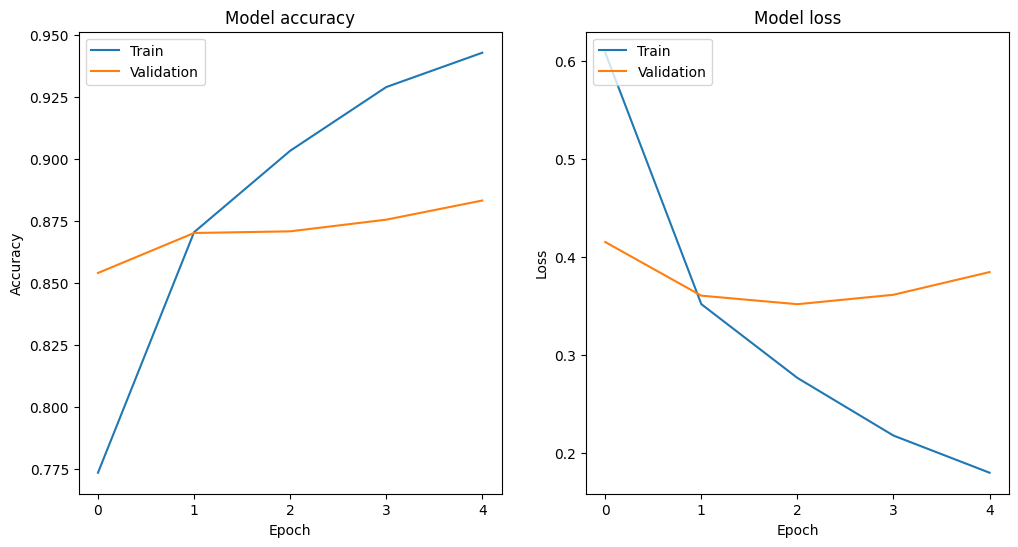

117/117 [==============================] - 4s 38ms/step


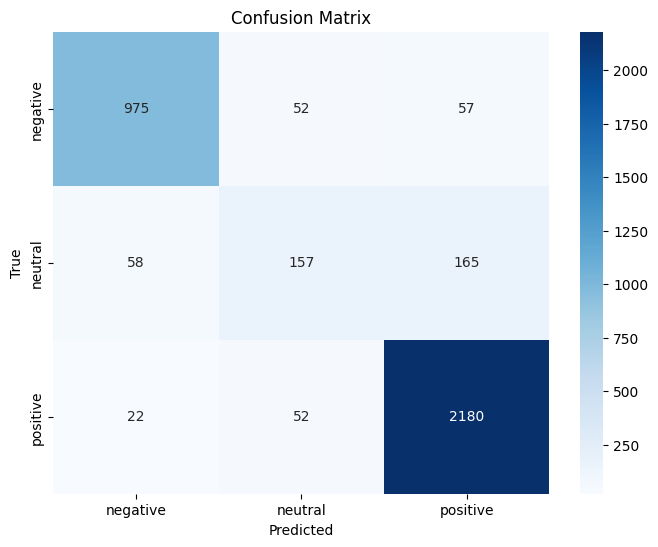

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, len(history.history['accuracy']), step=1))  # Set x-axis ticks to whole numbers
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, len(history.history['loss']), step=1))  # Set x-axis ticks to whole numbers
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Predictions on the test set
predictions = model.predict(test_data_padded)
predicted_labels = [round(prediction.argmax()) for prediction in predictions]

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example new statement
new_statement = "This service is terrible"

# Tokenize and convert to sequences
new_statement_sequence = tokenizer.texts_to_sequences([new_statement])

# Pad the sequence
new_statement_padded = pad_sequences(new_statement_sequence, maxlen=max_sequence_length)

# Make a prediction
prediction = model.predict(new_statement_padded)

# Convert prediction to class label
predicted_label = label_encoder.classes_[prediction.argmax()]

print(f"Predicted Sentiment: {predicted_label}")

1/1 [==============================] - 0s 37ms/step
Predicted Sentiment: negative


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example new statement
new_statement = "I love this service."

# Tokenize and convert to sequences
new_statement_sequence = tokenizer.texts_to_sequences([new_statement])

# Pad the sequence
new_statement_padded = pad_sequences(new_statement_sequence, maxlen=max_sequence_length)

# Make a prediction
prediction = model.predict(new_statement_padded)

# Convert prediction to class label
predicted_label = label_encoder.classes_[prediction.argmax()]

print(f"Predicted Sentiment: {predicted_label}")

1/1 [==============================] - 0s 36ms/step
Predicted Sentiment: positive
